This notebook is doing a monte carlo simulation of bushfire risk using the vegetation index

In [187]:
from path import Path
import arrow
import json
import pytz
from pprint import pprint
from tqdm import tqdm_notebook as tqdm
import re, os, collections, itertools, uuid, logging
import tempfile

import zipfile
import urllib

import ee
import pyproj
import numpy as np
import scipy as sp
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
import seaborn as sns
import shapely


%matplotlib inline
# %precision 4
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12, 6) # bigger plots
sns.set_palette("Set2", 10)

In [188]:
helper_dir = str(Path('.').abspath())
if helper_dir not in os.sys.path:
    os.sys.path.append(helper_dir)
    
from leak_helpers.earth_engine import display_ee, get_boundary, tifs2np, bands_s2, download_image, bands_s1, bands_l7, bands_l8
from leak_helpers.visualization import imshow_bands

# Params

In [304]:
# init
crs_grid = 3857 # projected wgs84
# if the satelite's note included in the metadata jsut add it

resolution_min=30 # 30m min
distance=3000
pixel_length=int(distance/resolution_min)

# black saturday
time = arrow.get('2009-02-08')
point = shapely.geometry.Point(145.3408333333,-37.5327777778) # Kingslake, where some black sat fire started
# point = shapely.geometry.Point(116.7413748,-31.8739154) # york, WA, AY

# time = arrow.get('2015-02-08')
# point = shapely.geometry.Point(115.833333,-31.933333) # perth

pixels=2.0*distance/resolution_min
print('pixels',pixels,pixels)

pixels 200.0 200.0


In [305]:
# uid = uuid.uuid4().hex
# temp_dir = cache_dir = Path(tempfile.mkdtemp())

In [306]:
ts = time.utcnow().format('YYYYMMDD-HHmmss')
folder_name = 'X{x:3.5f}_Y{y:3.5}_DT{time:}'.format(x=point.x,y=point.y,time=ts)
# image_folder = Path('../images/').joinpath(folder_name)
# image_folder.makedirs_p()

# download image

In [307]:
import ee
ee.Initialize() # should give no errors, if so follow instructions

# get boundary to crop/search image with
coords = np.array(point.xy)[:, 0].tolist()
geom = ee.Geometry.Point(coords)
bound = ee.Geometry.buffer(geometry=geom, distance=distance)
boundary = bound.bounds()

## vegetation index

## download landsat image bands

In [308]:
satellite='LANDSAT/LC8_L1T_ANNUAL_EVI'
bands=bands_l8

In [309]:
# search for image
sentinel2_before = ee.ImageCollection(satellite)\
    .filterBounds(boundary)\
    .sort('system:time_start', opt_ascending=False) # first will be latest
assert sentinel2_before.size().getInfo()>0,'oh no, no image results'
image = ee.Image(sentinel2_before.first()).clip(boundary)
info = image.getInfo()
image

In [310]:
path,files=download_image(
    image, 
    scale=resolution_min, 
    crs=crs_grid, 
#     name=arrow.now().format('YYYYMMDD-HH-mm-ss'),
    report=True,
    cache_dir=Path('../images'),
    name=folder_name
)
path, files

download?docid=46e2fc9e3a4e8dd0503a8b745: 156KB [00:05, 30.9KB/s] 


(Path('../images/X145.34083_Y-37.533_DT20170427-093030_3857_30'),
 ['2017.EVI.tfw', '2017.EVI.tif'])

/home/isisilon/.pyenv/versions/3.6.0/envs/jupyter3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


/home/isisilon/.pyenv/versions/3.6.0/envs/jupyter3/lib/python3.6/site-packages/matplotlib/colors.py:821: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/home/isisilon/.pyenv/versions/3.6.0/envs/jupyter3/lib/python3.6/site-packages/numpy/ma/core.py:2766: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)


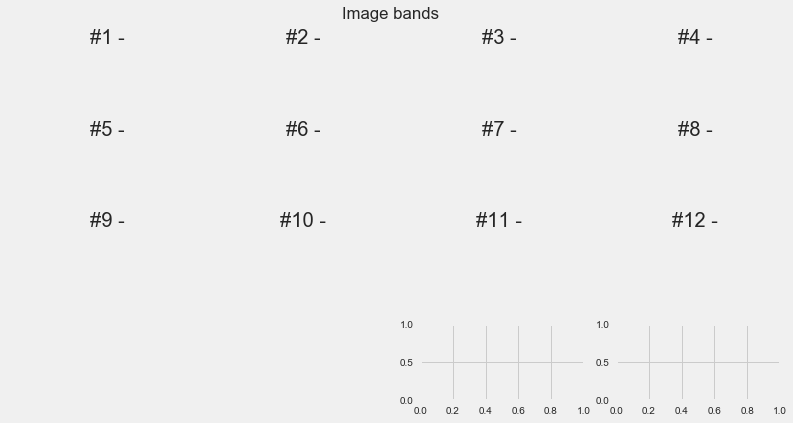

In [311]:
# view
X = tifs2np(path, files, bands=bands)
for i in range(X.shape[0]):
    x=X[i]
    X[i]=(x-x.min())/(x.max()-x.min())
imshow_bands(X, labels=None)

In [325]:
X.min(),X.max(),X[0]

(0.018720241,
 61440.0,
 array([[ 0.1677708 ,  0.16762105,  0.16762105, ...,  0.16818266,
          0.16818266,  0.16848217],
        [ 0.1677708 ,  0.16780825,  0.16780825, ...,  0.16833241,
          0.16833241,  0.16926843],
        [ 0.16732152,  0.16732152,  0.16732152, ...,  0.16833241,
          0.16833241,  0.16926843],
        ..., 
        [ 0.15384294,  0.15406759,  0.15665099, ...,  0.17409825,
          0.1738736 ,  0.17304991],
        [ 0.15593961,  0.1560145 ,  0.15837325, ...,  0.17484705,
          0.17372385,  0.17323712],
        [ 0.15593961,  0.1560145 ,  0.15837325, ...,  0.17424801,
          0.17252575,  0.17207646]], dtype=float32))

# download normal bands

In [326]:
satellite='LANDSAT/LC8_L1T_TOA'
bands=bands_l8

In [327]:
# search for image
sentinel2_before = ee.ImageCollection(satellite)\
    .filterBounds(boundary)\
    .sort('system:time_start', opt_ascending=False) # first will be latest
assert sentinel2_before.size().getInfo()>0,'oh no, no image results'
image = ee.Image(sentinel2_before.first()).clip(boundary)
info = image.getInfo()
image

In [328]:
path,files=download_image(
    image, 
    scale=resolution_min, 
    crs=crs_grid, 
#     name=arrow.now().format('YYYYMMDD-HH-mm-ss'),
    report=True,
    cache_dir=Path('../images'),
    name=folder_name
)
path,files

download?docid=bbca9b79be932f6a22c789065: 1.08MB [00:05, 198KB/s] 


(Path('../images/X145.34083_Y-37.533_DT20170427-093030_3857_30'),
 ['LC80930862017109LGN00.B5.tfw',
  '2017.EVI.png',
  '2017.EVI.tfw',
  '2017.EVI.tif',
  'LC80930862017109LGN00.B1.png',
  'LC80930862017109LGN00.B1.tfw',
  'LC80930862017109LGN00.B1.tif',
  'LC80930862017109LGN00.B10.png',
  'LC80930862017109LGN00.B10.tfw',
  'LC80930862017109LGN00.B10.tif',
  'LC80930862017109LGN00.B11.png',
  'LC80930862017109LGN00.B11.tfw',
  'LC80930862017109LGN00.B11.tif',
  'LC80930862017109LGN00.B2.png',
  'LC80930862017109LGN00.B2.tfw',
  'LC80930862017109LGN00.B2.tif',
  'LC80930862017109LGN00.B3.png',
  'LC80930862017109LGN00.B3.tfw',
  'LC80930862017109LGN00.B3.tif',
  'LC80930862017109LGN00.B4.png',
  'LC80930862017109LGN00.B4.tfw',
  'LC80930862017109LGN00.B4.tif',
  'LC80930862017109LGN00.B5.png',
  'LC80930862017109LGN00.B5.tif',
  'LC80930862017109LGN00.B6.png',
  'LC80930862017109LGN00.B6.tfw',
  'LC80930862017109LGN00.B6.tif',
  'LC80930862017109LGN00.B7.png',
  'LC80930862017109LGN00

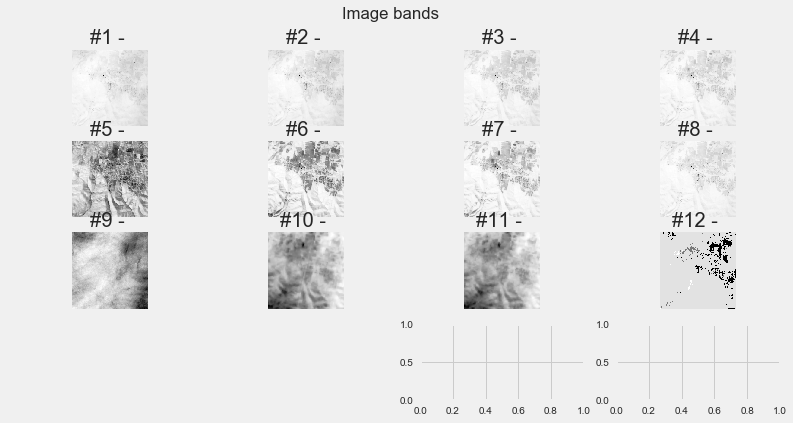

In [329]:
# view
X = tifs2np(path, files, bands=bands)
imshow_bands(X, labels=None)

In [330]:
# download elevation
satellite='AU/GA/AUSTRALIA_5M_DEM'
bands=bands_l8

In [331]:
# search for image
sentinel2_before = ee.ImageCollection(satellite)\
    .filterBounds(boundary)\
    .sort('system:time_start', opt_ascending=False) # first will be latest
assert sentinel2_before.size().getInfo()>0,'oh no, no image results'
image = ee.Image(sentinel2_before.first()).clip(boundary)
info = image.getInfo()
image

In [332]:
path,files=download_image(
    image, 
    scale=resolution_min, 
    crs=crs_grid, 
#     name=arrow.now().format('YYYYMMDD-HH-mm-ss'),
    report=True,
    cache_dir=Path('../images'),
    name=folder_name
)
path,file

download?docid=42debe55808f5713ce7c7f293: 8.19KB [00:03, 2.62KB/s]


(Path('../images/X145.34083_Y-37.533_DT20170427-093030_3857_30'),
 Path('../images/X145.34083_Y-37.533_DT20170427-093030_3857_30/NSW.elevation.tif'))

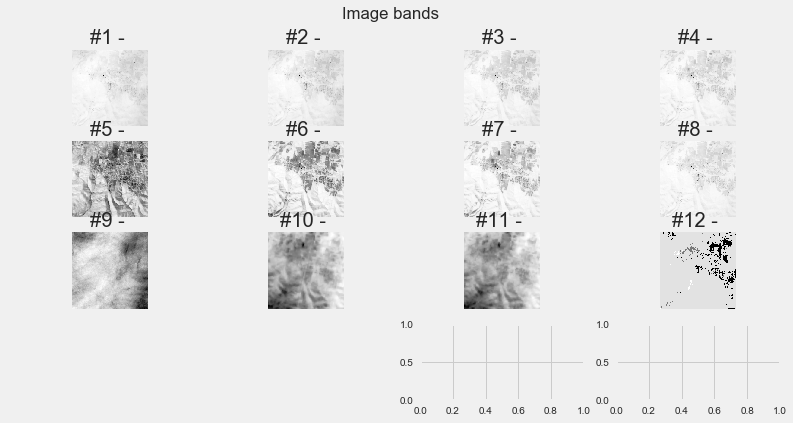

In [333]:
# view
X = tifs2np(path, files, bands=bands)
imshow_bands(X, labels=None)

## convert to png and normalise

In [334]:
# convert to png and normalise to 0-1
from scipy.misc import imread
for file in path.glob('*.tif'):
    if not file.endswith('tif'): continue
    impath = file
    impath_out = impath.replace('.tif','.png')
#     X = plt.imread(impath)
    X = imread(impath)
    print(X.min(),X.max(),X.shape)
    # normalise it
    X=(X-X.min())/(X.max()-X.min()+1e-7)
    print(X.min(),X.max())
    plt.imsave(impath_out,X,format='png')
    print(impath_out)


-0.0324864 0.958588 (253, 252)
0.0 1.0
../images/X145.34083_Y-37.533_DT20170427-093030_3857_30/2017.EVI.png
0.141525 0.258639 (253, 252)
0.0 0.999999
../images/X145.34083_Y-37.533_DT20170427-093030_3857_30/LC80930862017109LGN00.B1.png
277.026 284.245 (253, 252)
0.0 1.0
../images/X145.34083_Y-37.533_DT20170427-093030_3857_30/LC80930862017109LGN00.B10.png
275.422 282.402 (253, 252)
0.0 1.0
../images/X145.34083_Y-37.533_DT20170427-093030_3857_30/LC80930862017109LGN00.B11.png
0.116665 0.236736 (253, 252)
0.0 0.999999
../images/X145.34083_Y-37.533_DT20170427-093030_3857_30/LC80930862017109LGN00.B2.png
0.0831179 0.244711 (253, 252)
0.0 0.999999
../images/X145.34083_Y-37.533_DT20170427-093030_3857_30/LC80930862017109LGN00.B3.png
0.0656706 0.25145 (253, 252)
0.0 0.999999
../images/X145.34083_Y-37.533_DT20170427-093030_3857_30/LC80930862017109LGN00.B4.png
0.108952 0.452169 (253, 252)
0.0 1.0
../images/X145.34083_Y-37.533_DT20170427-093030_3857_30/LC80930862017109LGN00.B5.png
0.0555991 0.338836 

(3, 253, 252)


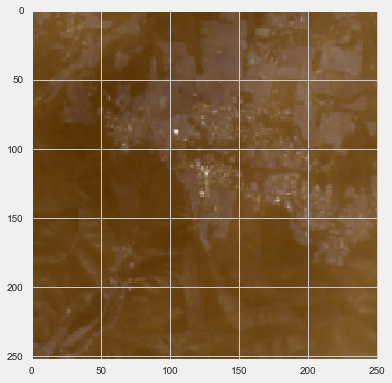

In [335]:
# view rgb
X = tifs2np(path, files, bands=bands_l8[:3])
print(X.shape)
X=(X-X.min())/(X.max()-X.min())
X=np.transpose(X,(1,2,0))
plt.imshow(X)

(12, 253, 252)
../images/AU_GA_AUSTRALIA_5M_DEM_NSW_B1.png


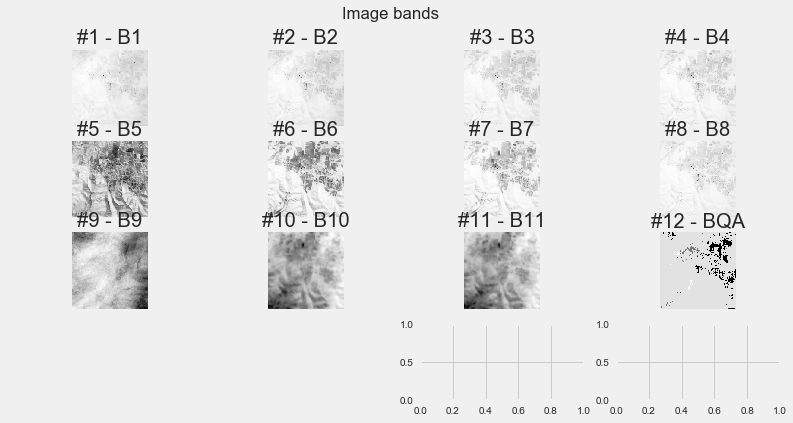

In [336]:
# view
X = tifs2np(path, files, bands=bands)
print(X.shape)
imshow_bands(X, labels=bands)
impath='../images/{}_{}.png'.format(info['id'].replace('/','_'),bands[0])
plt.imsave(impath,X[0])
print(impath)

In [337]:
# this van be the var images = ... in index.html
[str(p).replace('../','') for p in path.glob('*.png')]

['images/X145.34083_Y-37.533_DT20170427-093030_3857_30/2017.EVI.png',
 'images/X145.34083_Y-37.533_DT20170427-093030_3857_30/LC80930862017109LGN00.B1.png',
 'images/X145.34083_Y-37.533_DT20170427-093030_3857_30/LC80930862017109LGN00.B10.png',
 'images/X145.34083_Y-37.533_DT20170427-093030_3857_30/LC80930862017109LGN00.B11.png',
 'images/X145.34083_Y-37.533_DT20170427-093030_3857_30/LC80930862017109LGN00.B2.png',
 'images/X145.34083_Y-37.533_DT20170427-093030_3857_30/LC80930862017109LGN00.B3.png',
 'images/X145.34083_Y-37.533_DT20170427-093030_3857_30/LC80930862017109LGN00.B4.png',
 'images/X145.34083_Y-37.533_DT20170427-093030_3857_30/LC80930862017109LGN00.B5.png',
 'images/X145.34083_Y-37.533_DT20170427-093030_3857_30/LC80930862017109LGN00.B6.png',
 'images/X145.34083_Y-37.533_DT20170427-093030_3857_30/LC80930862017109LGN00.B7.png',
 'images/X145.34083_Y-37.533_DT20170427-093030_3857_30/LC80930862017109LGN00.B8.png',
 'images/X145.34083_Y-37.533_DT20170427-093030_3857_30/LC80930862017